# Vorticity balances across three Atlantic zonal sections

In this notebook, we display:

* An Atlantic map showing depth-integral transport and the location of the three zonal sections
* The depth-dependent vorticity equation across the subpolar north Atlantic zonal section
* All four depth-integral vorticity equations, integrated zonally from the western boundary of each zonal Atlantic section

# 0. Preliminary settings

## Required modules and methods

In [1]:
#!/usr/bin/python3.7
# General:
%load_ext autoreload
%autoreload
import numpy as np
import xarray as xr
import sys
import os

# Plots
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Specific to the VoBiN package:
sys.path.append(os.path.abspath("../output"))
sys.path.append(os.path.abspath("../lib"))
from plot_methods import global_map,vertical_section,section_contour,global_quiver,global_contour,global_hatching,atl_line,atl_zonal,zonal_profile,atl_map_zonal_lines
from general_methods import norm,log10
from grid_methods import zint,search_lon,search_lat,ubot,ucline

## Loading the data

In [4]:
names=['meshmask','utrd2','ztrd','ztrd2','ztrd_int','ztrd2_int','curl_utrd_int','curl_utrd2_int','curl_utrd_av','curl_utrd2_av',
       'curl_utrd_transp','curl_utrd2_transp']
for name in names:
    exec(name+'=xr.open_dataset("../output/'+name+'.nc")')

# derivation of vertical integral u for interpretation purposes
u_int=zint(utrd2.u,meshmask.e3u_0)
v_int=zint(utrd2.v,meshmask.e3v_0)
u_int=u_int.rolling(x=5, min_periods=1).mean().rolling(y=5, min_periods=1).mean()*meshmask.umask.isel(lev=0)
v_int=v_int.rolling(x=5, min_periods=1).mean().rolling(y=5, min_periods=1).mean()*meshmask.vmask.isel(lev=0)

# required variables
x=meshmask.fixed_glamt; x[-1,:]=x[-2,:]
y=meshmask.gphit
rho0=1025
b=meshmask.beta
fh=meshmask.div_fh

# 1. Atlantic zonal sections map

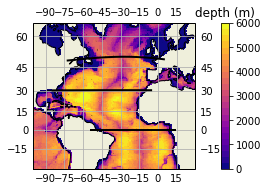

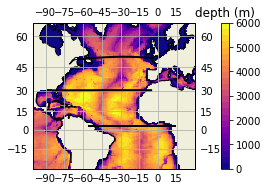

In [6]:
# figure properties
colorbar='plasma'
lev=np.linspace(0.,6000.,25)
name='bathy_Atl'

# Atlantic map with equatorial section at 0°N
ax=atl_map_zonal_lines(meshmask.glamt[:-1,:],
                    meshmask.gphit[:-1,:],
                    meshmask.bathy_t[:-1,:]*meshmask.tmask_nan[0,:-1,:],
                    lev,legend,colorbar,name)
global_quiver(ax,meshmask.glamt[:-1,:],meshmask.gphit[:-1,:],u_int[:-1,:],v_int[:-1,:],name,'k')
lims=[[50,-70,5],[30,-82,-5],[0,-53,15]]
for lim in lims:
    meshmask_x=zonal_profile(meshmask,meshmask,lim)
    atl_line(ax,meshmask_x.glamt,meshmask_x.gphit,name)

# Atlantic map with equatorial section at 3°N
name2='bathy_Atl2'
ax=atl_map_zonal_lines(meshmask.glamt[:-1,:],
                    meshmask.gphit[:-1,:],
                    meshmask.bathy_t[:-1,:]*meshmask.tmask_nan[0,:-1,:],
                    lev,legend,colorbar,name2)
global_quiver(ax,meshmask.glamt[:-1,:],meshmask.gphit[:-1,:],u_int[:-1,:],v_int[:-1,:],name2,'k')
lims2=[[50,-60,-5],[30,-82,-5],[3,-55,15]]
for lim in lims2:
    meshmask_x=zonal_profile(meshmask,meshmask,lim)
    atl_line(ax,meshmask_x.glamt,meshmask_x.gphit,name2)

## Depth-dependent vorticity budget - Atlantic zonal sections

/home/waldmanr/Bureau/Model/VoBiN/plot/plot_methods.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(20, 10))


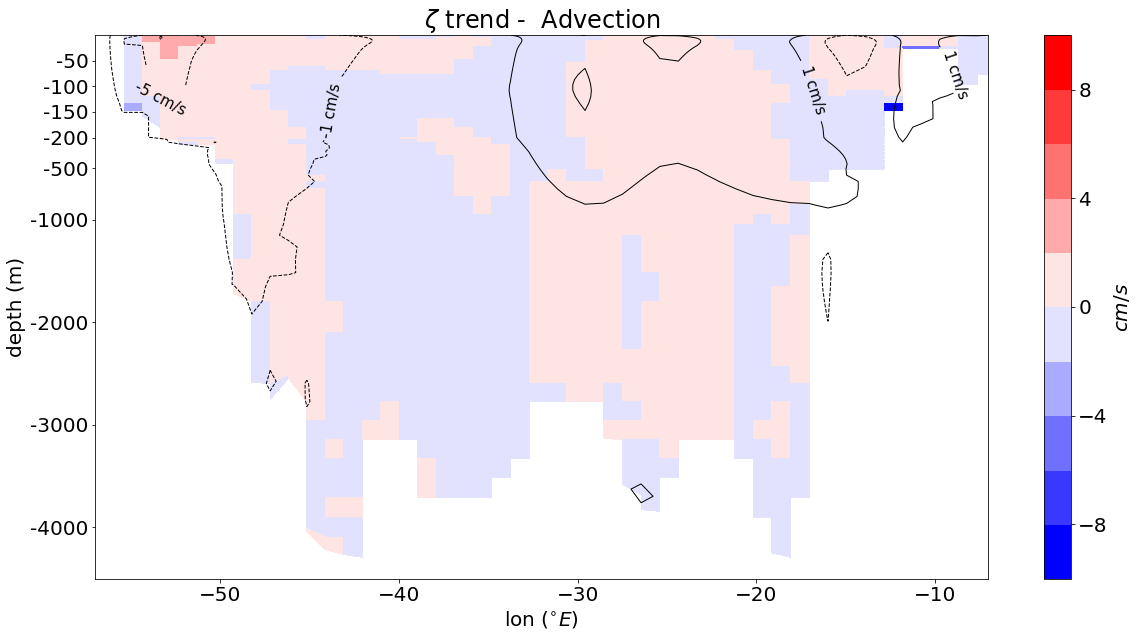

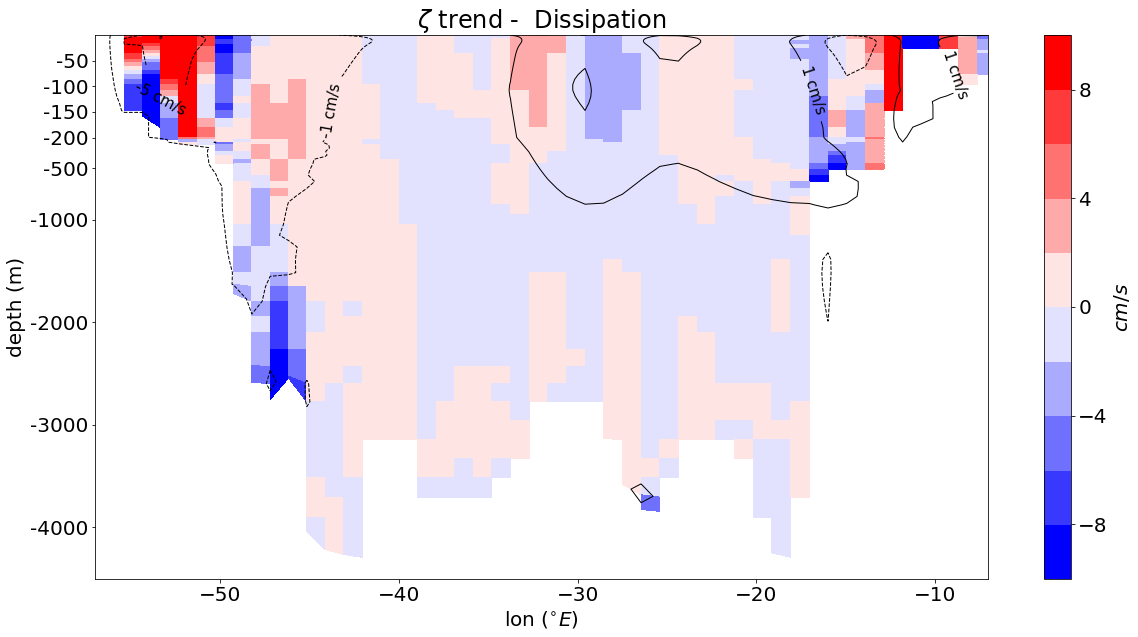

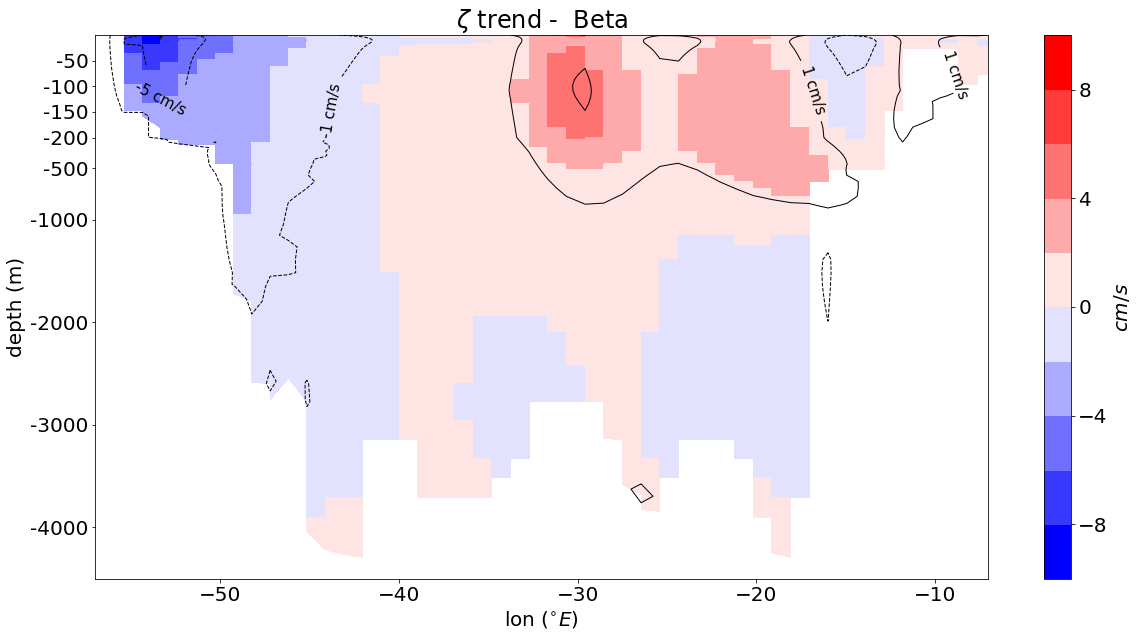

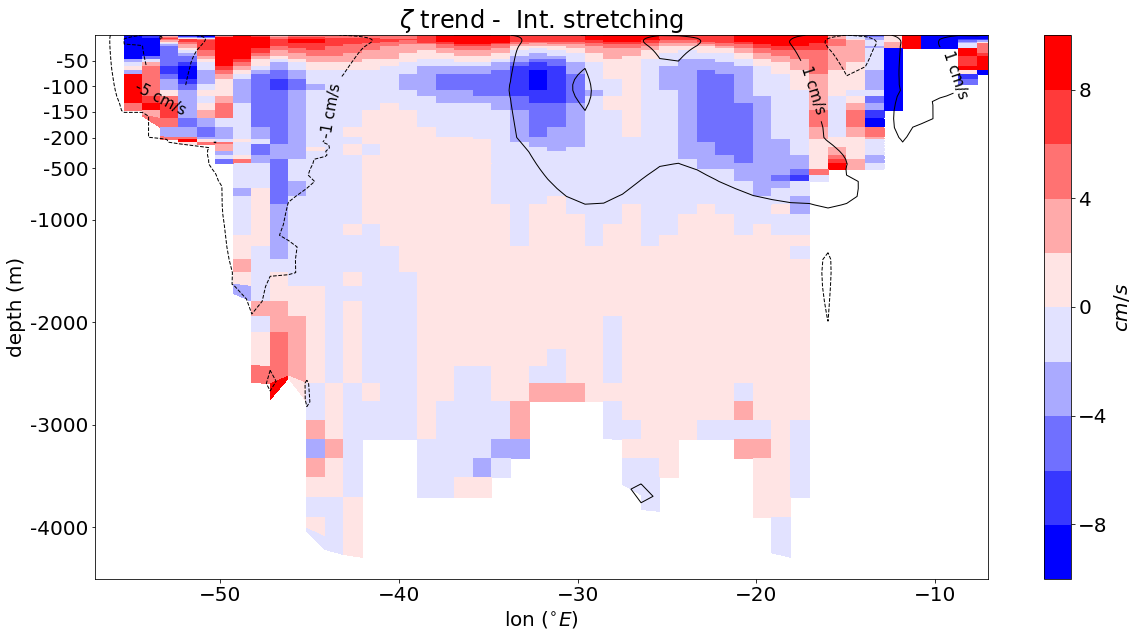

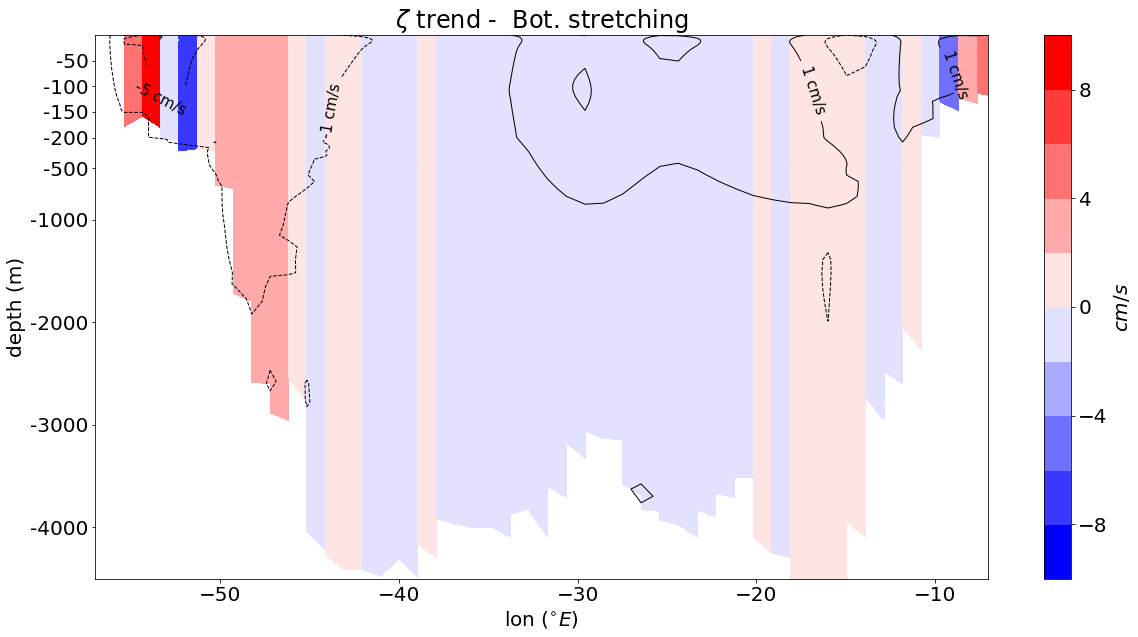

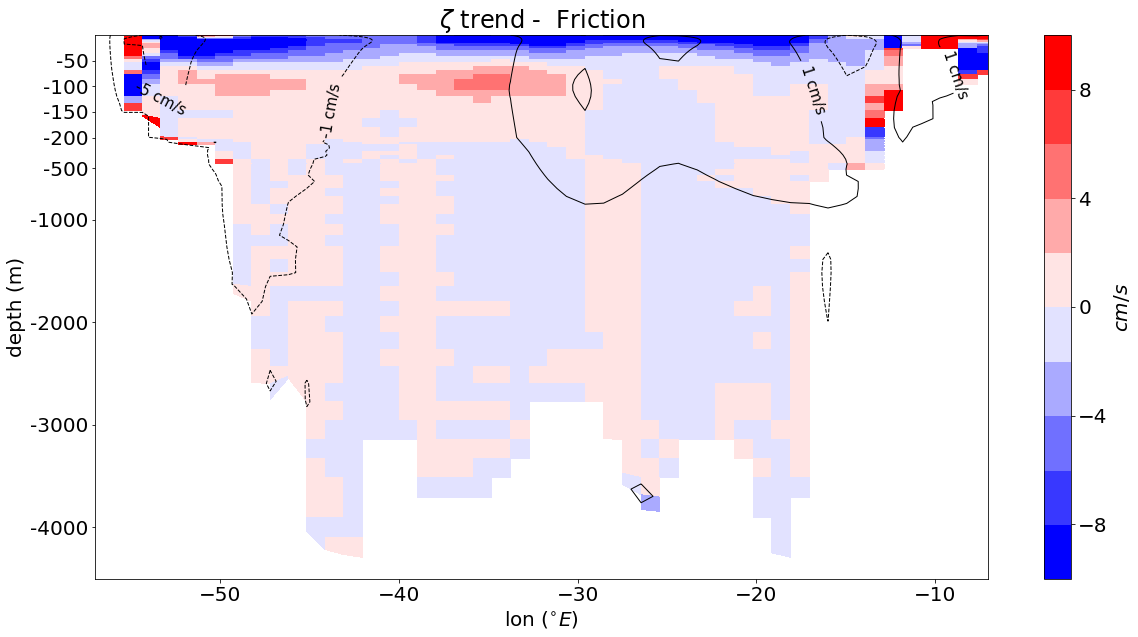

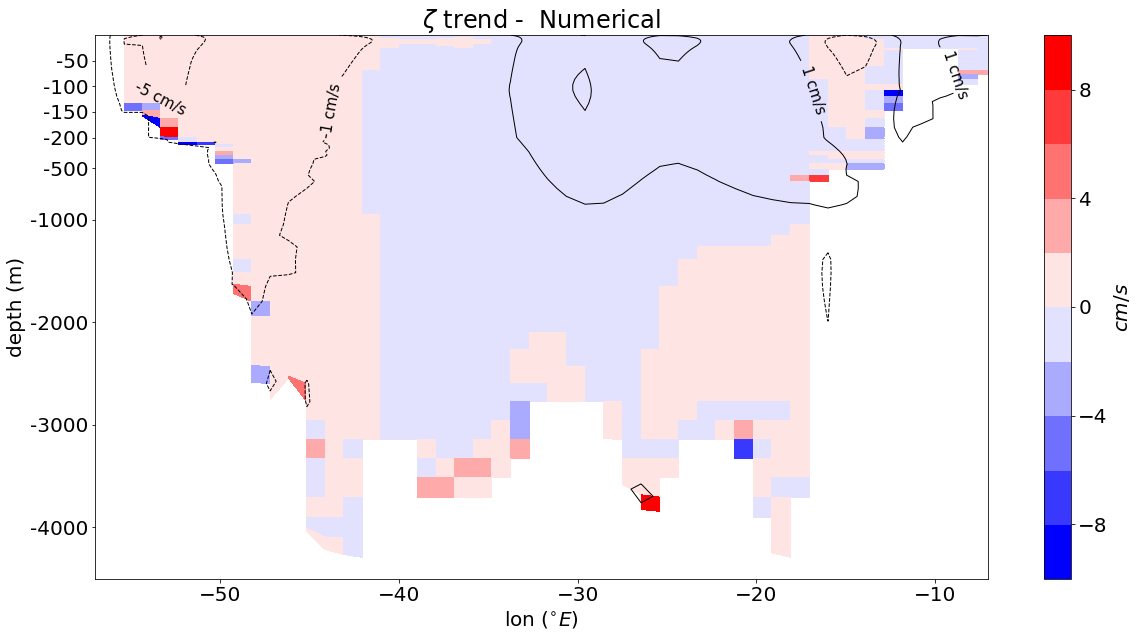

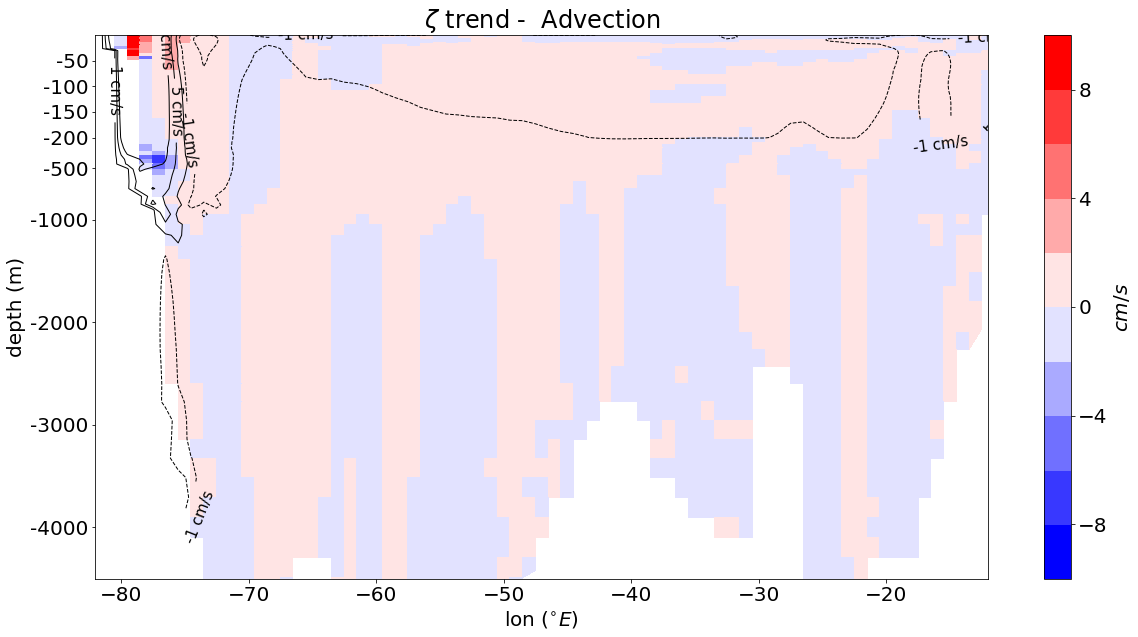

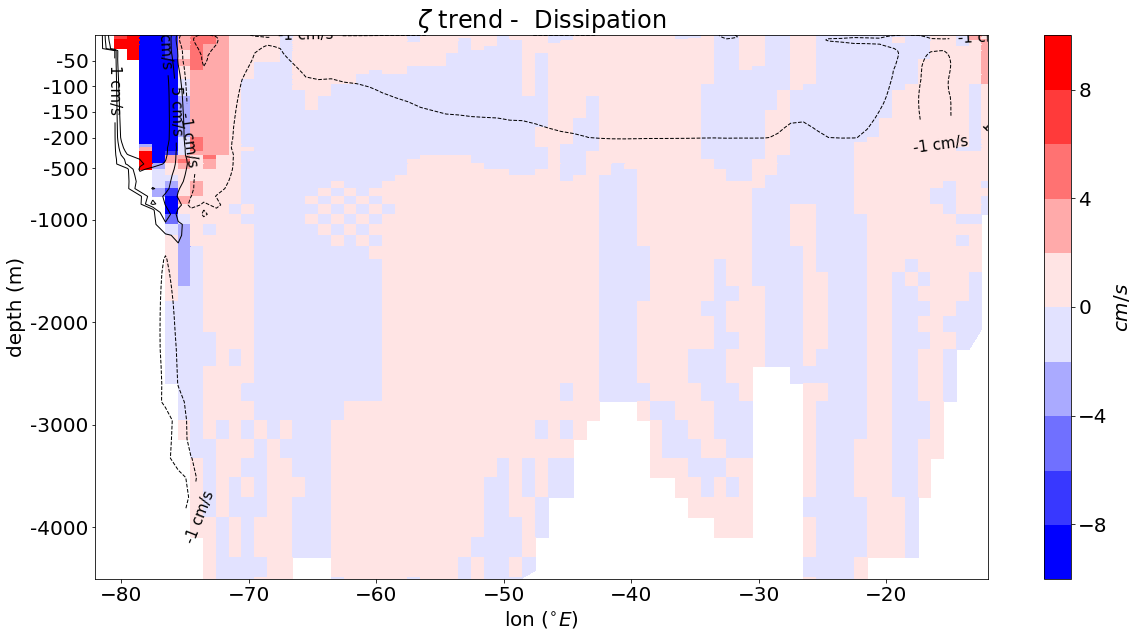

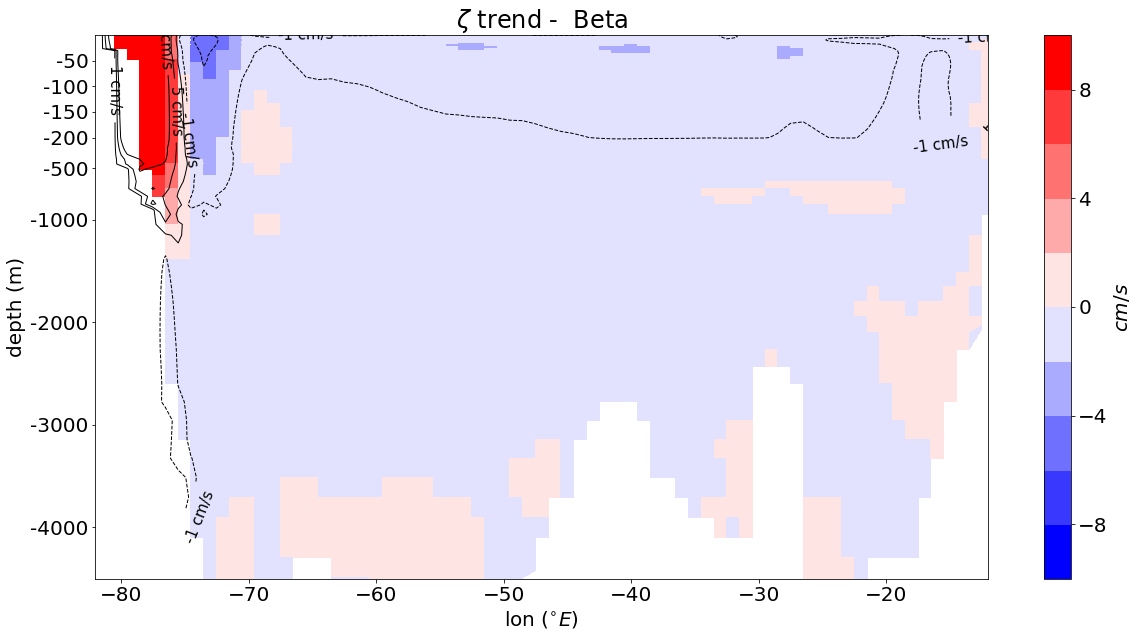

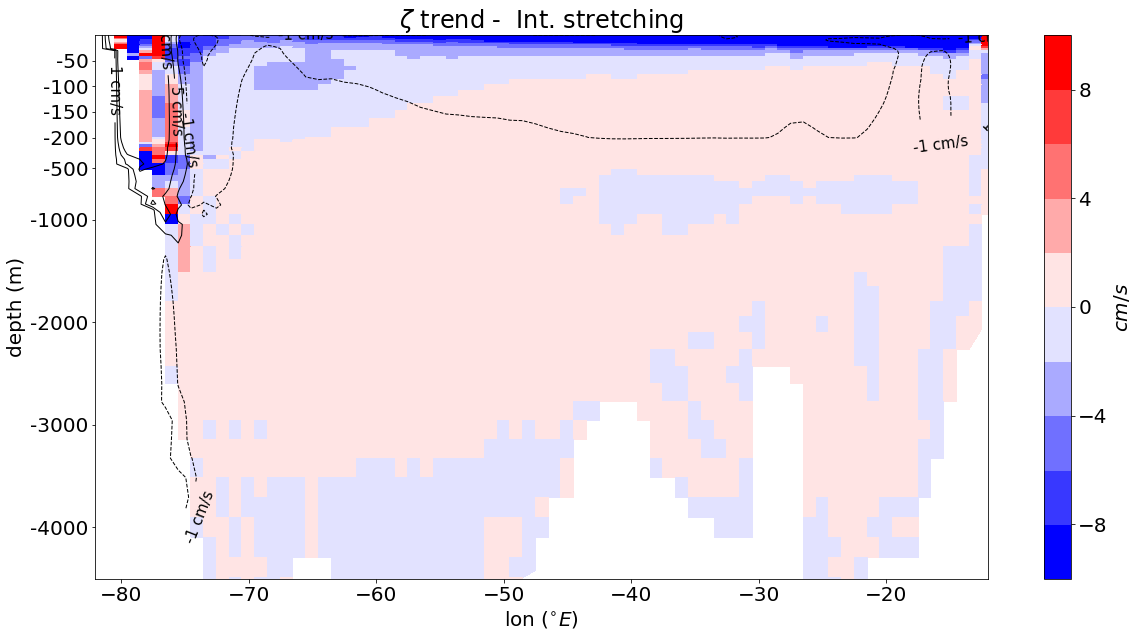

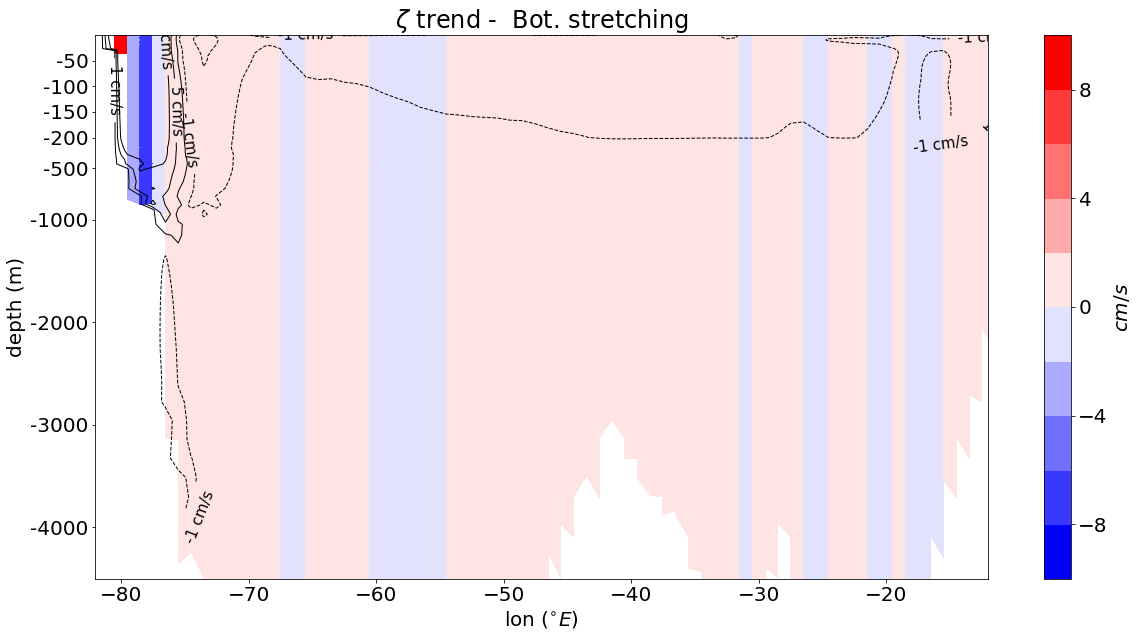

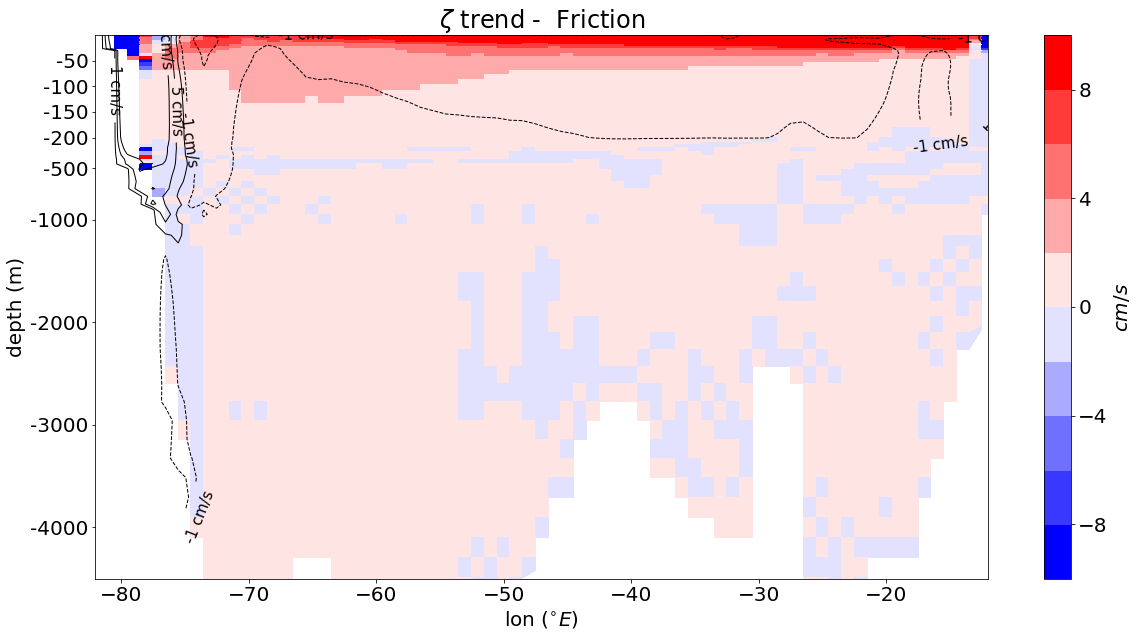

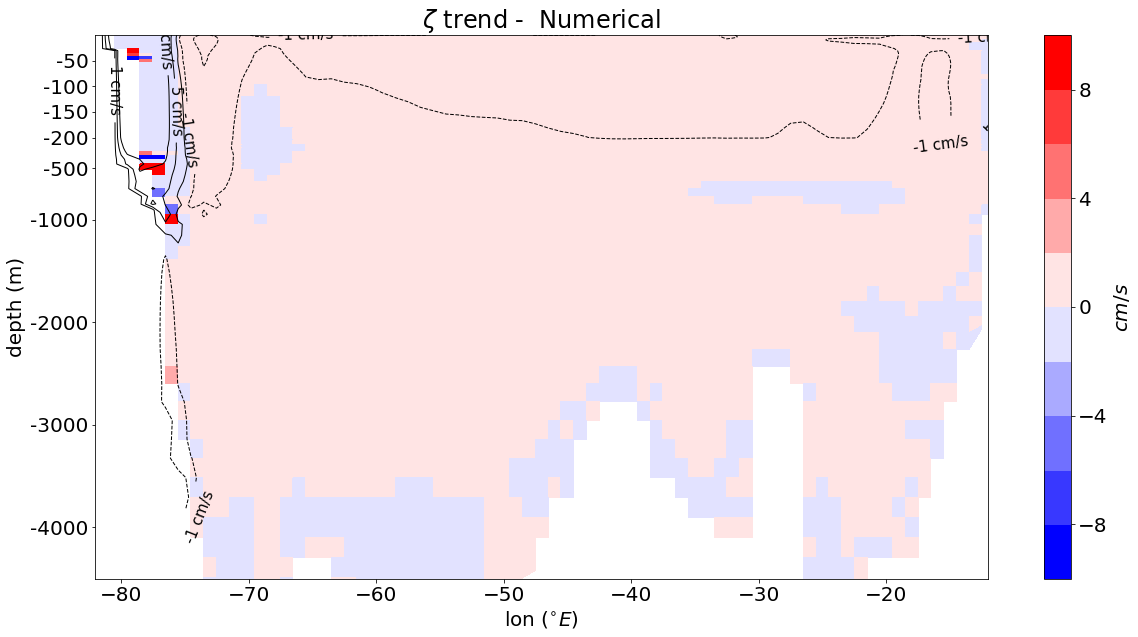

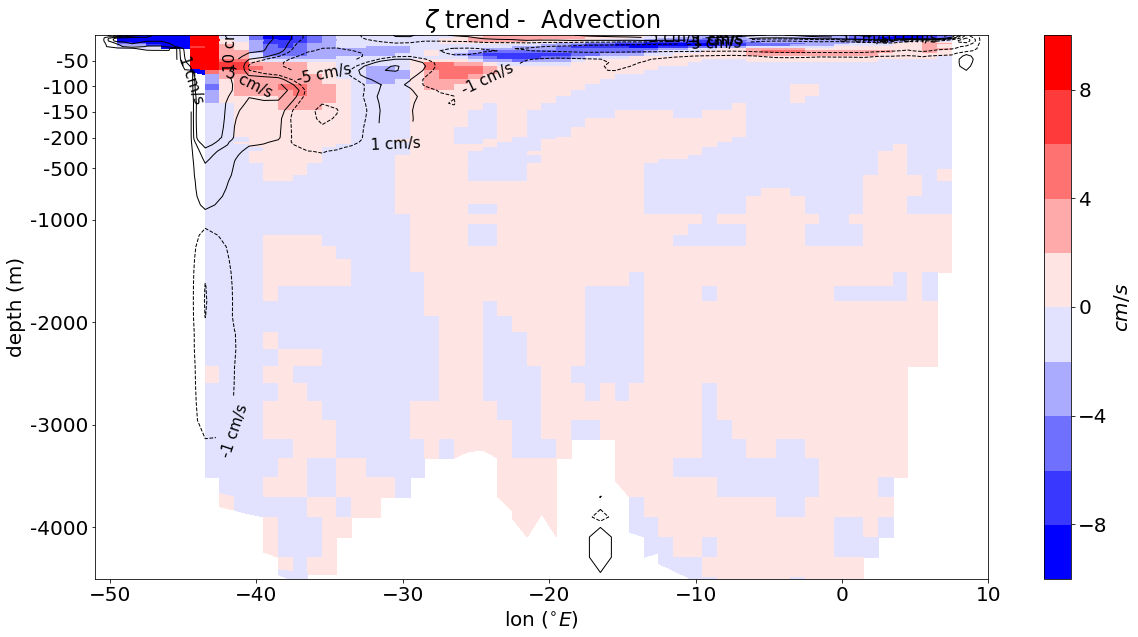

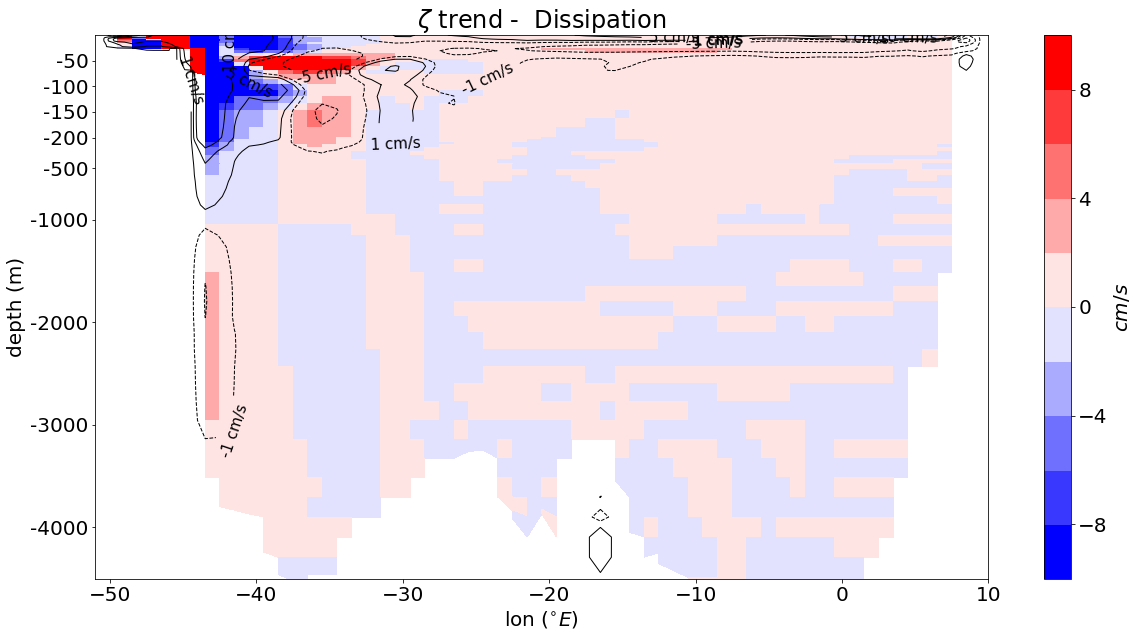

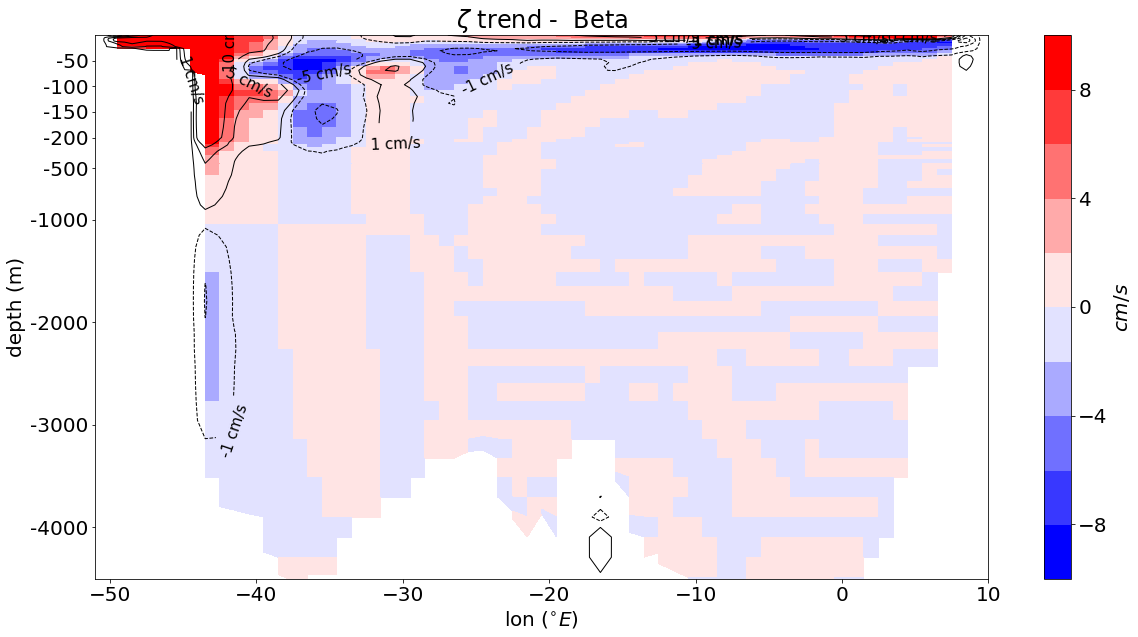

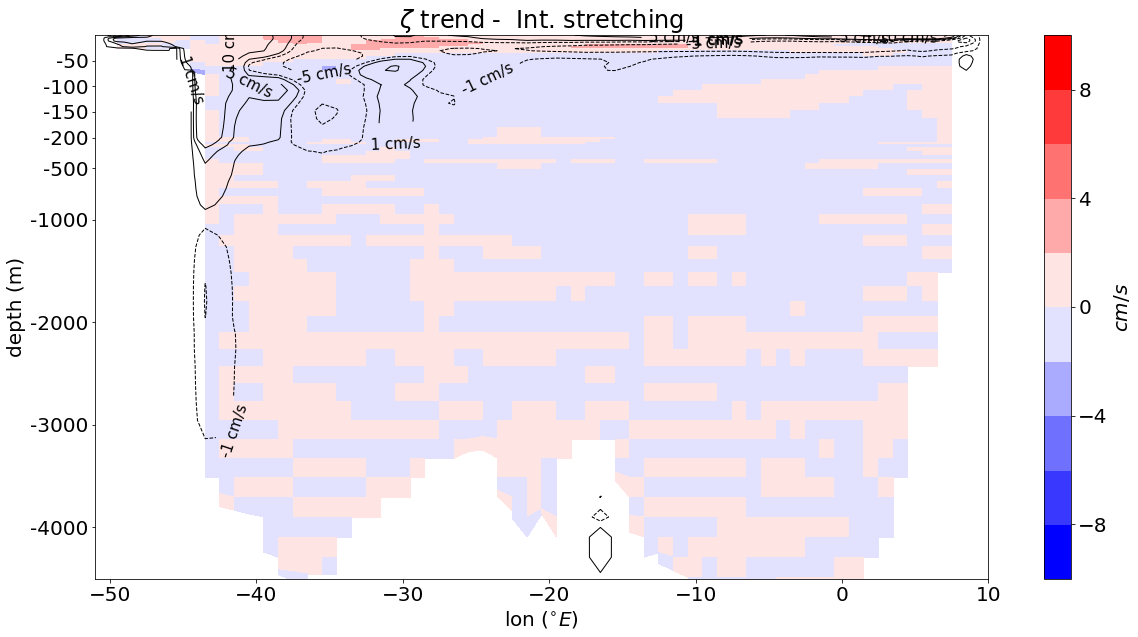

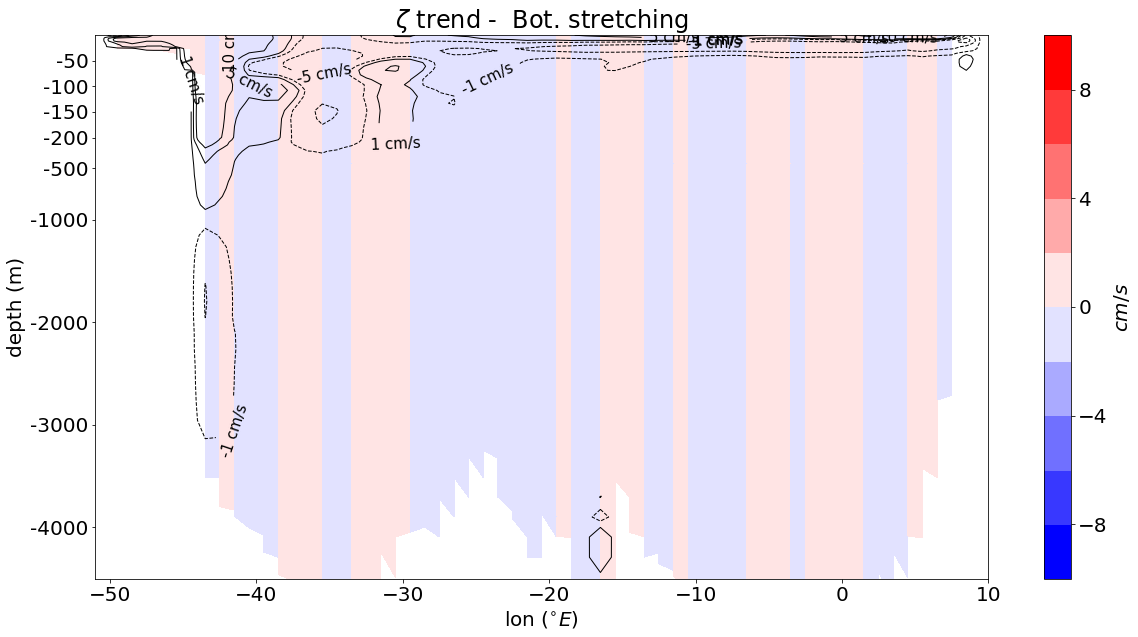

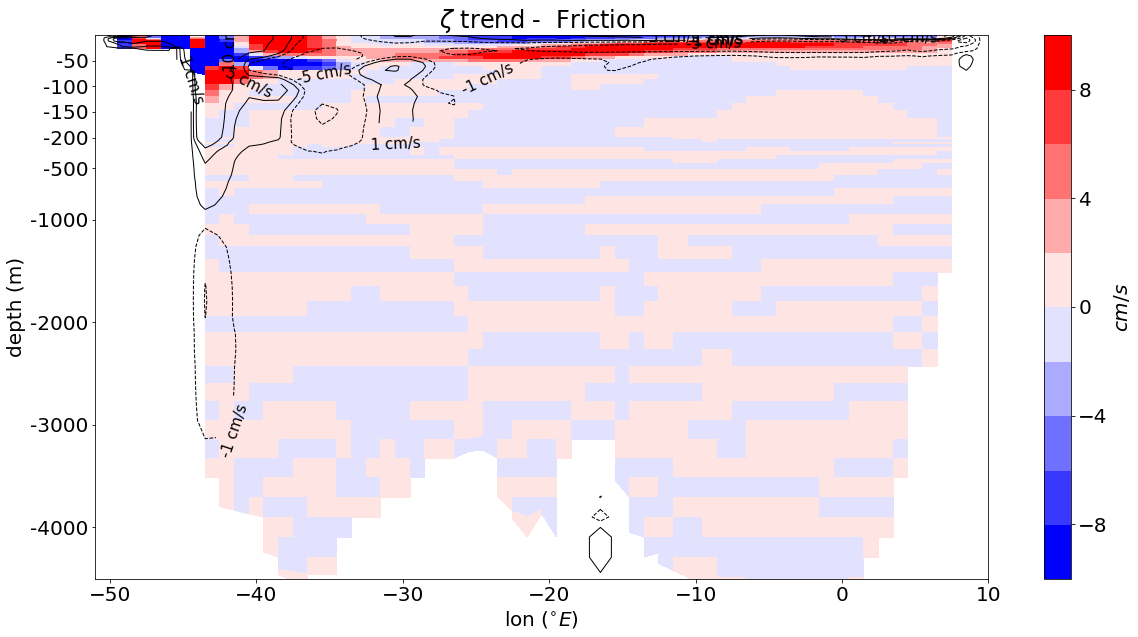

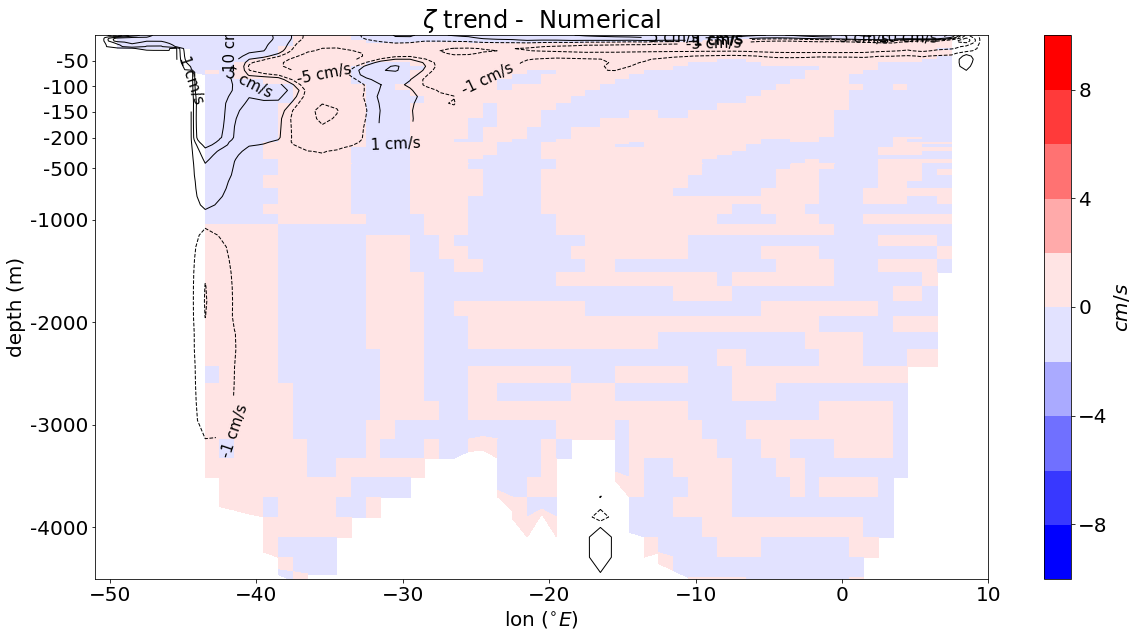

In [7]:
# Concatenation of 8 budget terms:
ztrd_budget=-xr.merge([xr.DataArray(ztrd.ztrdkeg+ztrd.ztrdrvo+ztrd.ztrdzad,name='ztrdad'),
                        ztrd.ztrdldf,ztrd2.ztrd_betaphys,
                        xr.DataArray(ztrd2.ztrd_stretchphys-ztrd2.ztrd_topo_stretch,name='ztrd_stretchint'),
                        ztrd2.ztrd_topo_stretch,
                        xr.DataArray(ztrd.ztrdspg+ztrd.ztrdzdf,name='ztrdzdf'),
                        xr.DataArray(ztrd2.ztrd_betanum+ztrd2.ztrd_stretchnum,name='ztrdnum')])/b

# Figure properties:
levs=np.linspace(-10,10,11)
title='$\zeta$ trend - '
unit='$cm/s$'
levs_v_yz=[-50, -10, -5, -1, 1, 5, 10, 50]
ylab='lon ($^{\circ}E$)'
zlab='depth (m)'
colorbar2='bwr'
xlims=[[-57,-7],[-82,-12],[-51,10]]

# Section plots:
names=['Advection','Dissipation','Beta','Int. stretching','Bot. stretching','Friction','Numerical','Residual']
terms=['ztrdad','ztrdldf','ztrd_betaphys','ztrd_stretchint','ztrd_topo_stretch','ztrdzdf','ztrdnum']
j=-1
for lim in lims:
    j+=1
    file='Z_budget_'+str(lim[0])
    frame=[xlims[j][0], xlims[j][1], -4500, -0.5]
    v_x=zonal_profile(utrd2.v,meshmask,lim)
    z_x=zonal_profile(-meshmask.gdept_0,meshmask,lim)
    z_x_stretch=z_x.copy()
    z_x_stretch.data[z_x_stretch.data<-200]=-200+(z_x_stretch.data[z_x_stretch.data<-200]+200)/5
    x_x=xr.ones_like(z_x)*zonal_profile(meshmask.glamt,meshmask,lim)
    ztrd_budget_x=zonal_profile(ztrd_budget,meshmask,lim)
    for i in range(0,len(terms)):
        cbar=vertical_section(x_x,z_x,
            eval('ztrd_budget_x.'+terms[i])*100,
            levs,unit,ylab,zlab,title+' '+names[i],colorbar2,file+terms[i],frame)
        section_contour(x_x,z_x_stretch,v_x*100,levs_v_yz,file+terms[i])

## Depth-integral vorticity equation, zonal integral

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


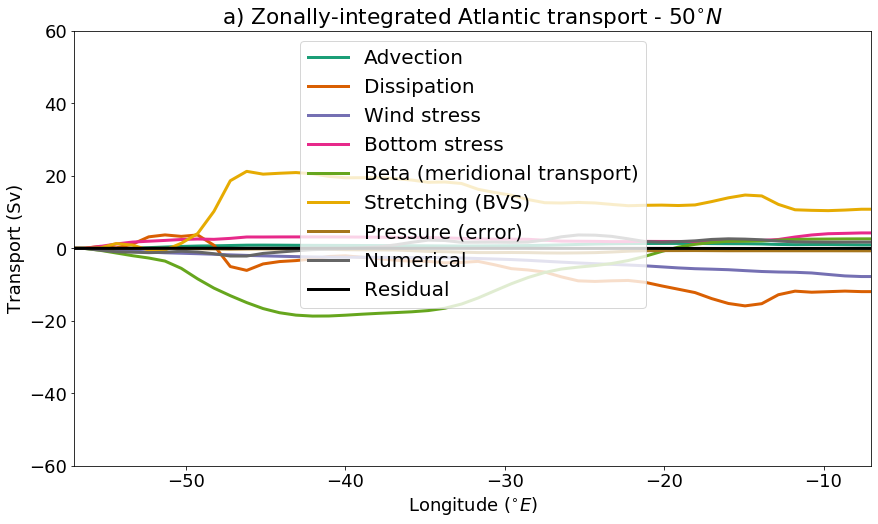

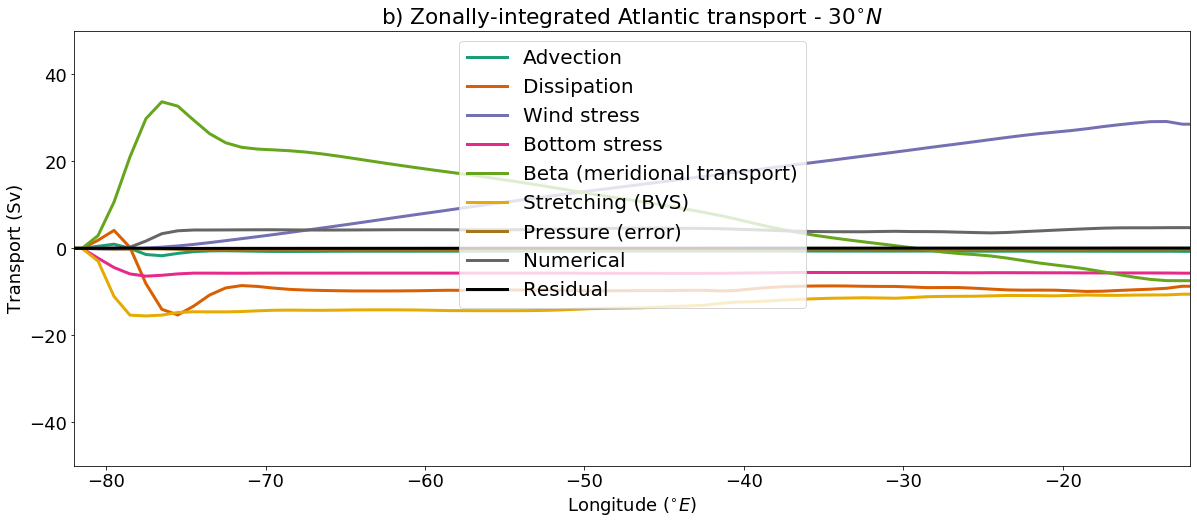

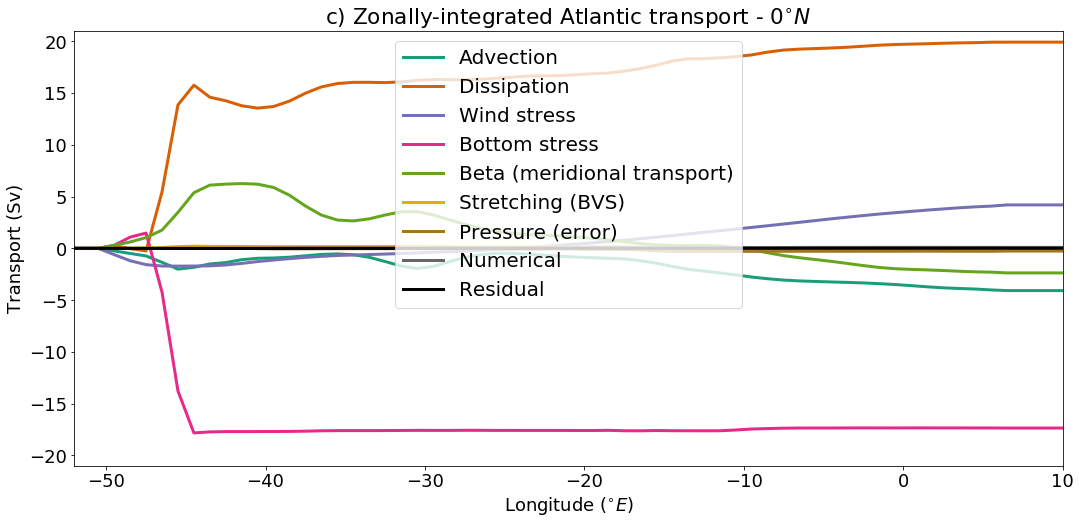

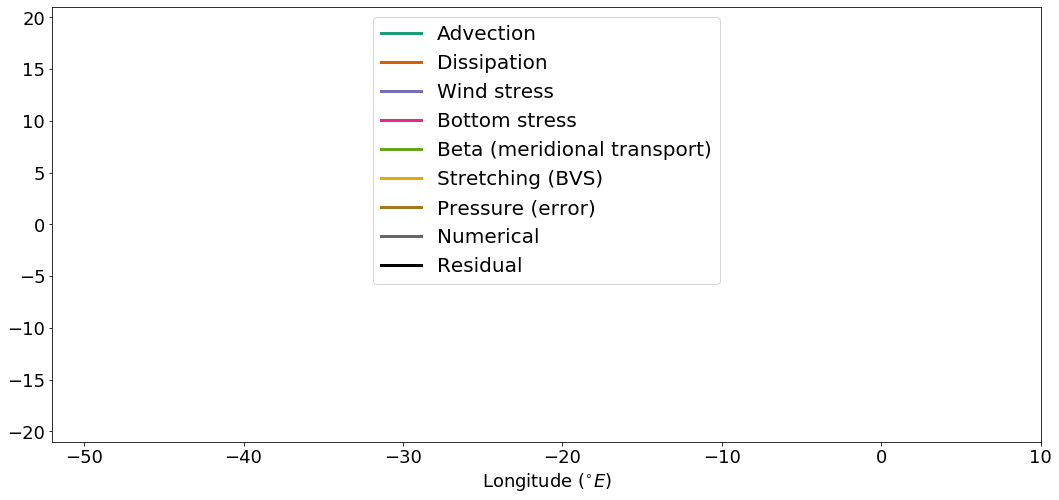

In [8]:
# Concatenation of 8 budget terms:
ztrd_int_budget=-xr.merge([xr.DataArray(ztrd_int.ztrdkeg+ztrd_int.ztrdrvo+ztrd_int.ztrdzad,name='ztrdad'),
                        ztrd_int.ztrdldf,ztrd2_int.ztrd_betaphys,ztrd2_int.ztrd_stretchphys,ztrd_int.ztrdhpg,
                        xr.DataArray(ztrd_int.ztrdtau/rho0,name='ztrdtau'),
                        xr.DataArray(ztrd_int.ztrdspg+ztrd_int.ztrdzdf-ztrd_int.ztrdtau/rho0,name='ztrdtaub'),
                        xr.DataArray(ztrd2_int.ztrd_betanum+ztrd2_int.ztrd_stretchnum,name='ztrdnum')])/b

# Figure properties:
names=['Advection','Dissipation','Wind stress','Bottom stress','Beta (meridional transport)','Stretching (BVS)','Pressure (error)','Numerical','Residual']
ranges=[60,50,21]
xlims=[[-57,-7],[-82,-12],[-52,10]]
labs=['a) ','b) ','c) ']

# zonal profile plots:
for i in range(0,len(lims)):
    ztrd_int_budget_x=zonal_profile(ztrd_int_budget,meshmask,lims[i])
    meshmask_x=zonal_profile(meshmask,meshmask,lims[i])
    ztrd_int_budget_xint=(ztrd_int_budget_x*meshmask_x.e1t).cumsum(dim='x')
    ztrd_int_budget_xint=ztrd_int_budget_xint.fillna(0)
    atl_zonal(ztrd_int_budget_xint/1e6,meshmask_x,names,[-ranges[i],ranges[i]],'Transport (Sv)',
              labs[i]+'Zonally-integrated Atlantic transport - $'+str(lims[i][0])+'^{\circ}N$','ztrd_int_budget_'+str(lims[i][0]),
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])

# empty plot with legend:
atl_zonal(ztrd_int_budget_xint*np.nan,meshmask_x,names,[-ranges[i],ranges[i]],'',
              '','zonal_legend_ztrd',
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])

## BV equation, zonally integrated

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


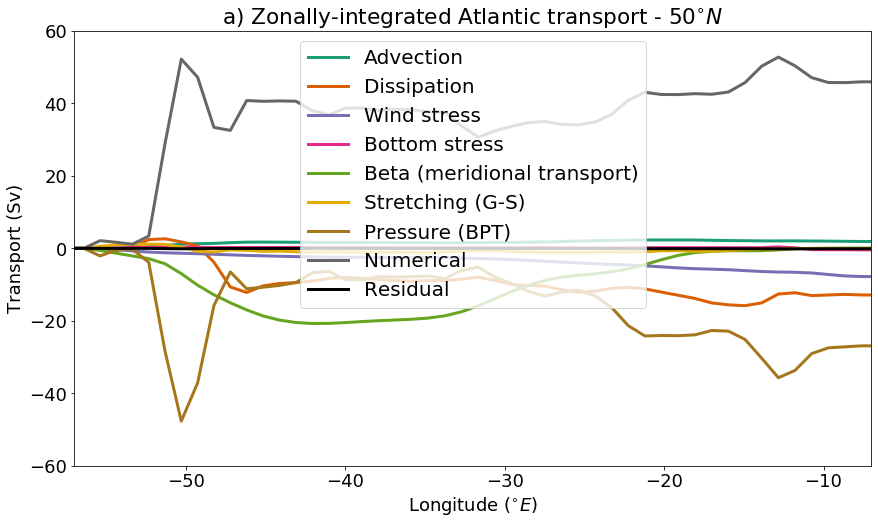

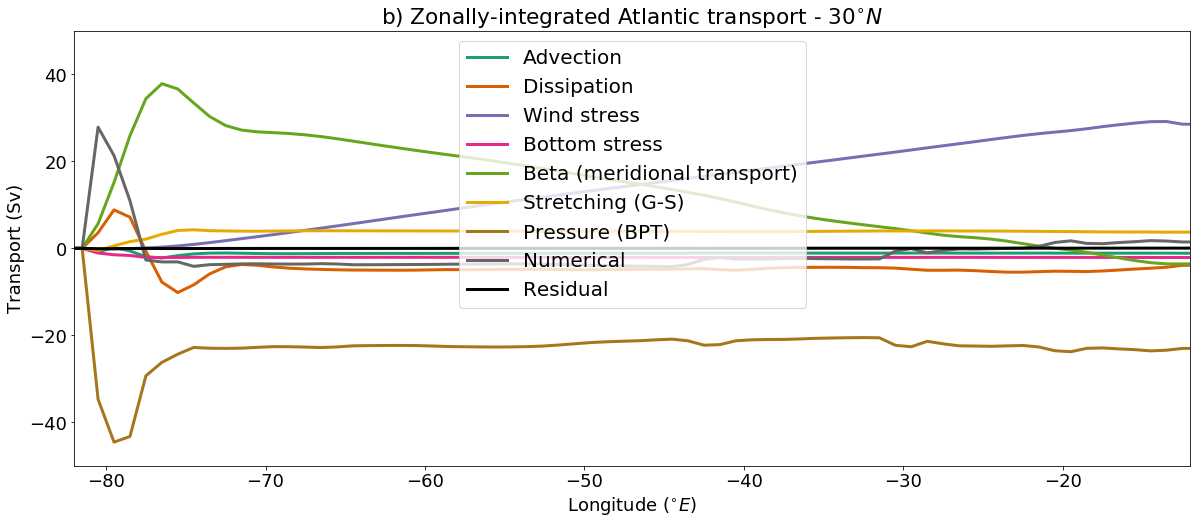

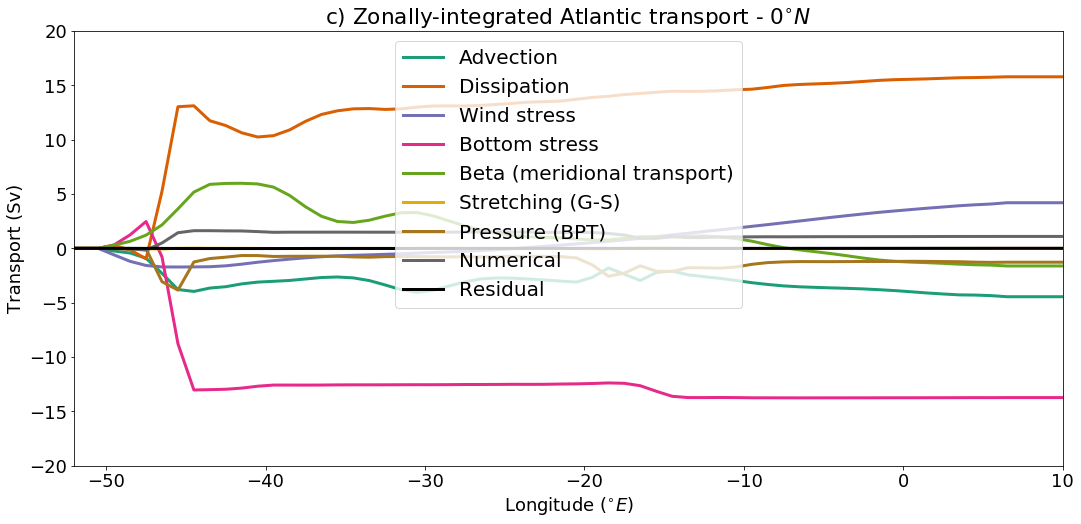

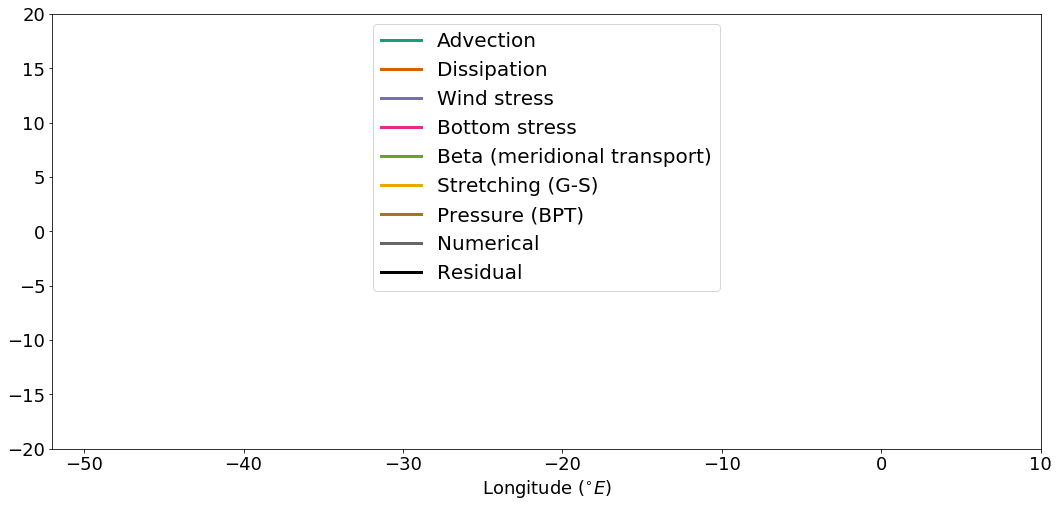

In [9]:
# Concatenation of 8 budget terms:
curl_utrd_int_budget=-xr.merge([xr.DataArray(curl_utrd_int.ztrdkeg+curl_utrd_int.ztrdrvo+curl_utrd_int.ztrdzad,name='ztrdad'),
                        curl_utrd_int.ztrdldf,curl_utrd2_int.ztrd_betaphys,curl_utrd2_int.ztrd_stretchphys,curl_utrd_int.ztrdhpg,
                        xr.DataArray(curl_utrd_int.ztrdtau/rho0,name='ztrdtau'),
                        xr.DataArray(curl_utrd_int.ztrdspg+curl_utrd_int.ztrdzdf-curl_utrd_int.ztrdtau/rho0,name='ztrdtaub'),
                        xr.DataArray(curl_utrd2_int.ztrd_betanum+curl_utrd2_int.ztrd_stretchnum+curl_utrd2_int.ztrd_crossnum,name='ztrdnum')])/b

# figure properties
names=['Advection','Dissipation','Wind stress','Bottom stress','Beta (meridional transport)','Stretching (G-S)','Pressure (BPT)','Numerical','Residual']
ranges=[60,50,20]

# zonal profile plots
for i in range(0,len(lims)):
    curl_utrd_int_budget_x=zonal_profile(curl_utrd_int_budget,meshmask,lims[i])
    meshmask_x=zonal_profile(meshmask,meshmask,lims[i])
    curl_utrd_int_budget_xint=(curl_utrd_int_budget_x*meshmask_x.e1t).cumsum(dim='x')
    atl_zonal(curl_utrd_int_budget_xint/1e6,meshmask_x,names,[-ranges[i],ranges[i]],'Transport (Sv)',
              labs[i]+'Zonally-integrated Atlantic transport - $'+str(lims[i][0])+'^{\circ}N$','curl_utrd_int_budget_'+str(lims[i][0]),
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])

# empty plot with legend:
atl_zonal(ztrd_int_budget_xint*np.nan,meshmask_x,names,[-ranges[i],ranges[i]],'',
              '','zonal_legend_curl_utrd',
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])

## Geostrophic contour vorticity equation, zonally integrated

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


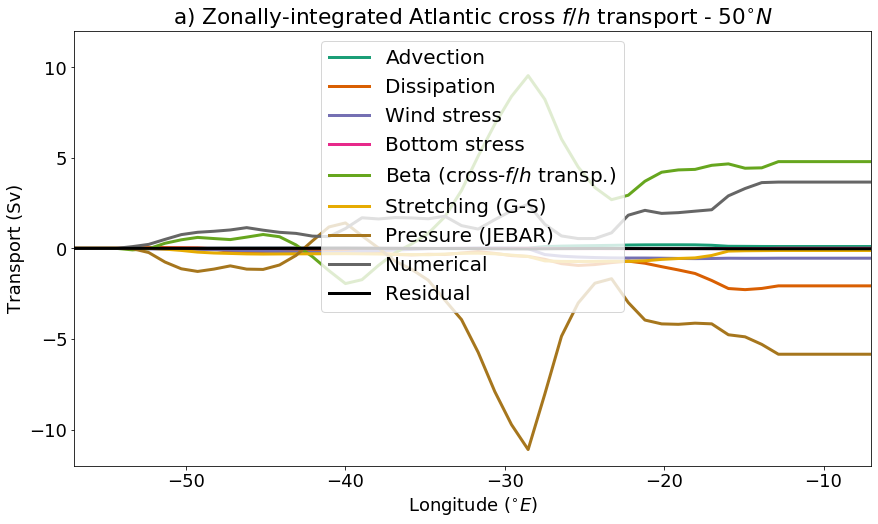

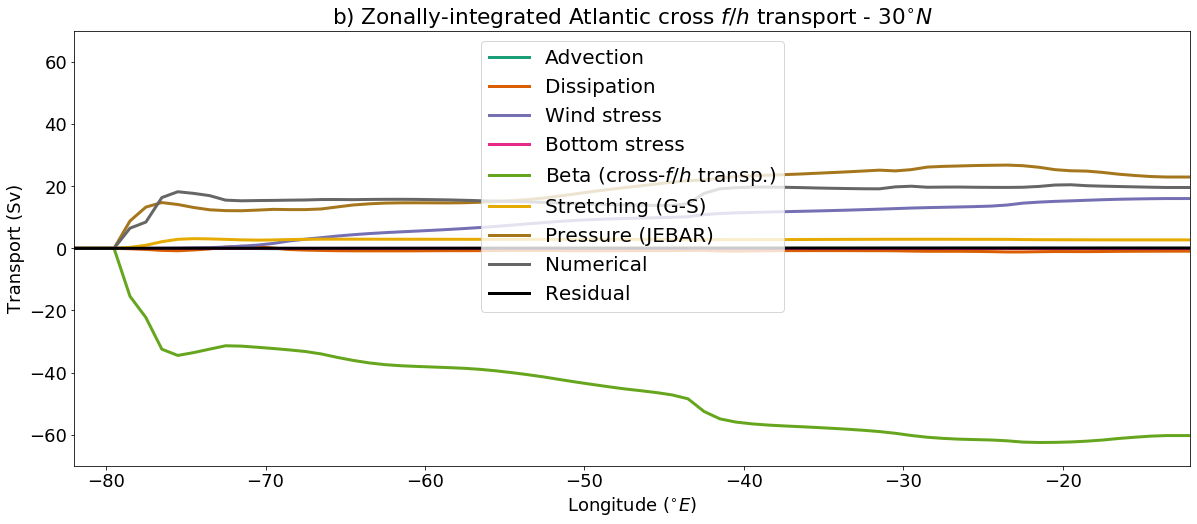

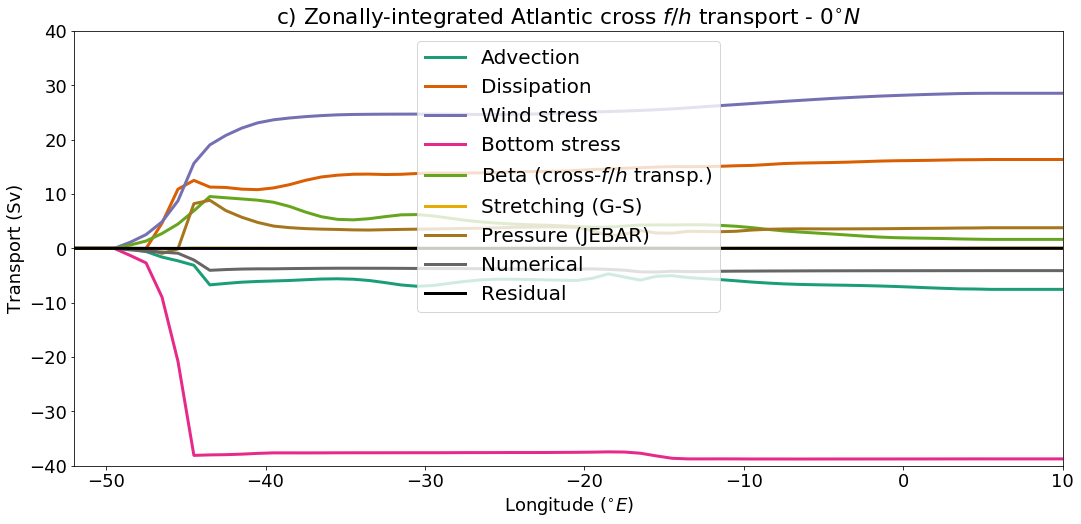

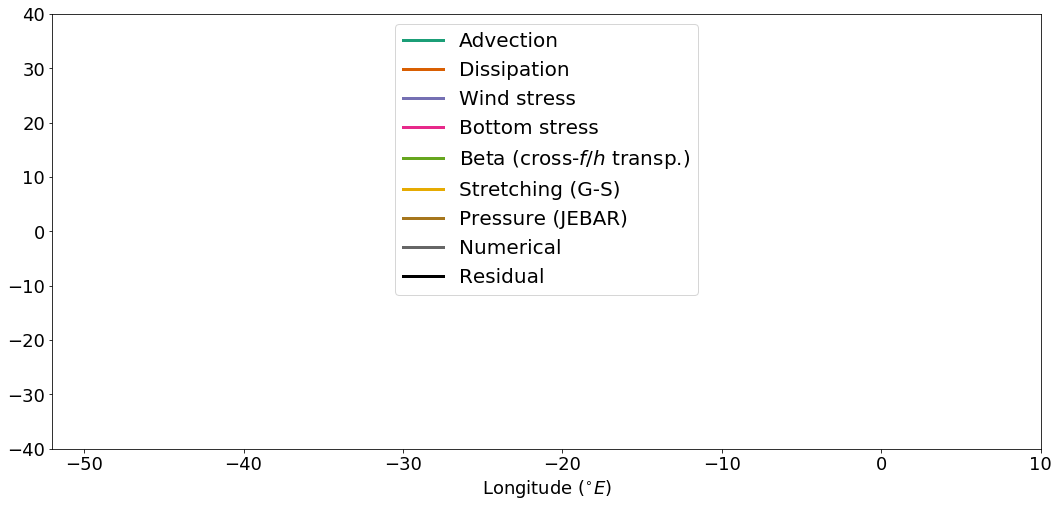

In [13]:
# Concatenation of 8 budget terms:
curl_utrd_av_budget=-xr.merge([xr.DataArray(curl_utrd_av.ztrdkeg+curl_utrd_av.ztrdrvo+curl_utrd_av.ztrdzad,name='ztrdad'),
                        curl_utrd_av.ztrdldf,curl_utrd2_av.ztrd_betaphys,curl_utrd2_av.ztrd_stretchphys,curl_utrd_av.ztrdhpg,
                        xr.DataArray(curl_utrd_av.ztrdtau/rho0,name='ztrdtau'),
                        xr.DataArray(curl_utrd_av.ztrdspg+curl_utrd_av.ztrdzdf-curl_utrd_av.ztrdtau/rho0,name='ztrdtaub'),
                        xr.DataArray(curl_utrd2_av.ztrd_betanum+curl_utrd2_av.ztrd_stretchnum+curl_utrd2_av.ztrd_crossnum,name='ztrdnum')])/fh

# figure properties
names=['Advection','Dissipation','Wind stress','Bottom stress','Beta (cross-$f/h$ transp.)','Stretching (G-S)','Pressure (JEBAR)','Numerical','Residual']
ranges=[12,70,40]

# zonal profile plots
for i in range(0,len(lims)):
    curl_utrd_av_budget_x=zonal_profile(curl_utrd_av_budget,meshmask,lims[i])
    # Undefine all terms where f/h is undefined
    mask=xr.where(np.isnan(curl_utrd_av_budget_x.ztrd_betaphys),np.nan,1)
    curl_utrd_av_budget_x=curl_utrd_av_budget_x*mask
    meshmask_x=zonal_profile(meshmask,meshmask,lims[i])
    curl_utrd_av_budget_xint=(curl_utrd_av_budget_x*meshmask_x.e1t).cumsum(dim='x')
    atl_zonal(curl_utrd_av_budget_xint/1e6,meshmask_x,names,[-ranges[i],ranges[i]],'Transport (Sv)',
              labs[i]+'Zonally-integrated Atlantic cross $f/h$ transport - $'+str(lims[i][0])+'^{\circ}N$','curl_utrd_av_budget_'+str(lims[i][0]),
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])
    
# empty plot with legend:
atl_zonal(ztrd_int_budget_xint*np.nan,meshmask_x,names,[-ranges[i],ranges[i]],'',
              '','zonal_legend_curl_utrd_av',
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])

## Transport divergence vorticity equation, zonally integrated

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


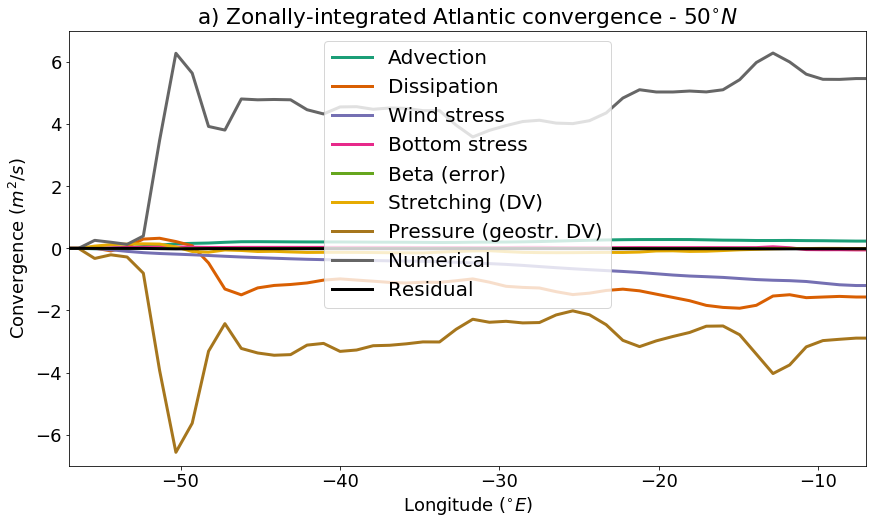

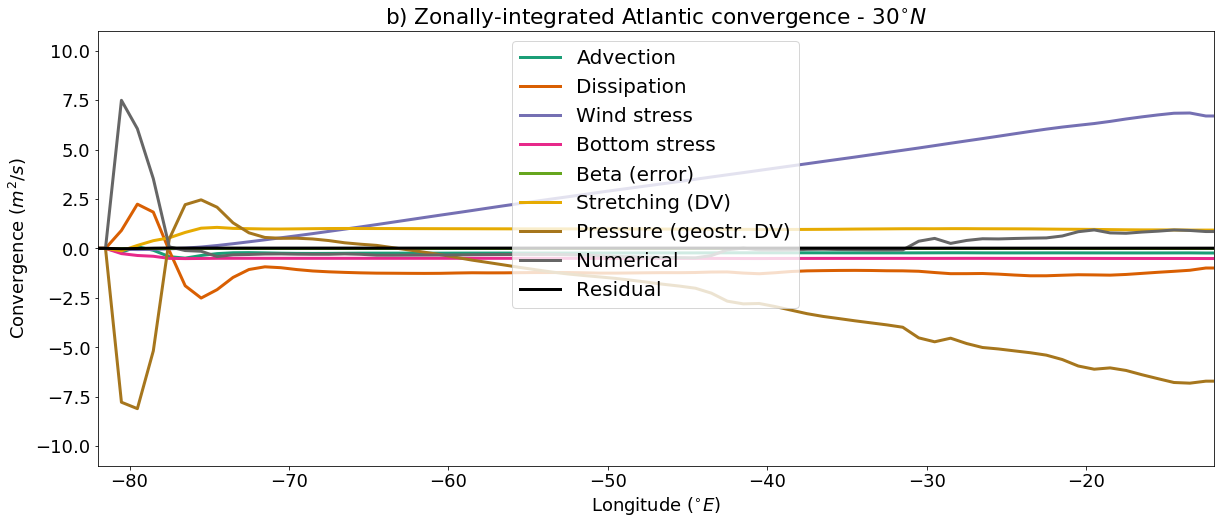

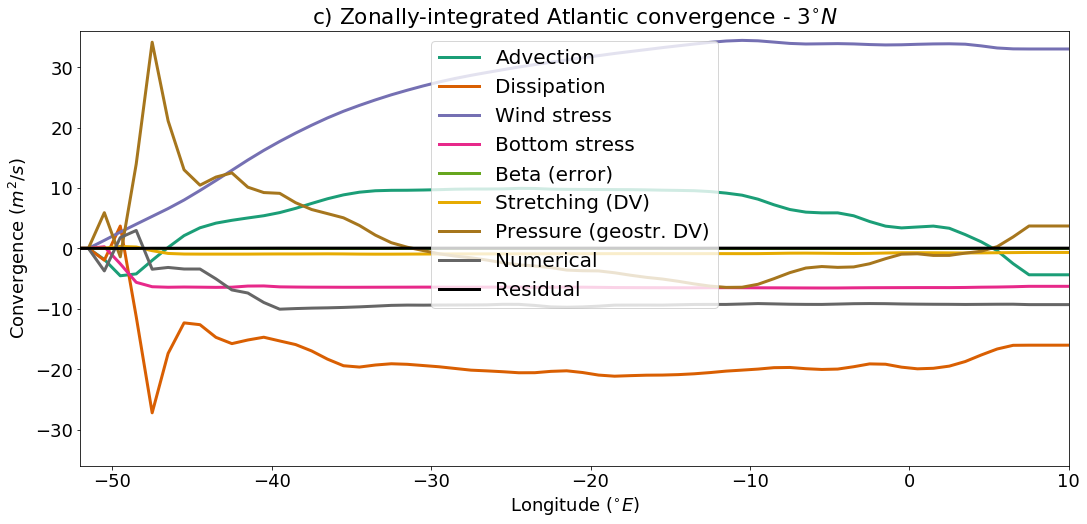

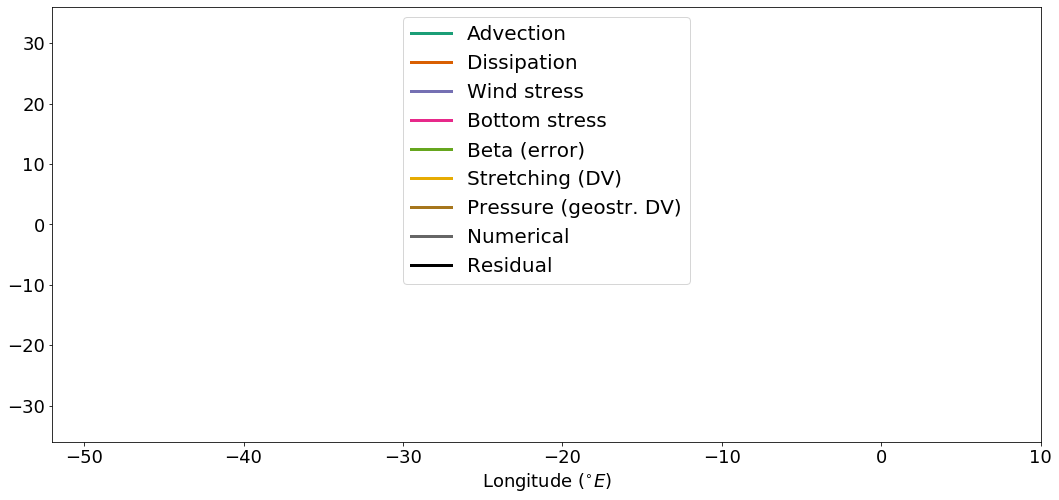

In [14]:
# Concatenation of 8 budget terms:
curl_utrd_transp_budget=-xr.merge([xr.DataArray(curl_utrd_transp.ztrdkeg+curl_utrd_transp.ztrdrvo+curl_utrd_transp.ztrdzad,name='ztrdad'),
                        curl_utrd_transp.ztrdldf,curl_utrd2_transp.ztrd_betaphys,curl_utrd2_transp.ztrd_stretchphys,curl_utrd_transp.ztrdhpg,
                        xr.DataArray(curl_utrd_transp.ztrdtau/rho0,name='ztrdtau'),
                        xr.DataArray(curl_utrd_transp.ztrdspg+curl_utrd_transp.ztrdzdf-curl_utrd_transp.ztrdtau/rho0,name='ztrdtaub'),
                        xr.DataArray(curl_utrd2_transp.ztrd_betanum+curl_utrd2_transp.ztrd_stretchnum+curl_utrd2_transp.ztrd_crossnum,name='ztrdnum')])

# figure properties
names=['Advection','Dissipation','Wind stress','Bottom stress','Beta (error)','Stretching (DV)','Pressure (geostr. DV)','Numerical','Residual']
ranges=[7,11,36]

# zonal profile plots
for i in range(0,len(lims2)):
    curl_utrd_transp_budget_x=zonal_profile(curl_utrd_transp_budget,meshmask,lims2[i])
    meshmask_x=zonal_profile(meshmask,meshmask,lims2[i])
    curl_utrd_transp_budget_xtransp=(curl_utrd_transp_budget_x*meshmask_x.e1t).cumsum(dim='x')
    atl_zonal(curl_utrd_transp_budget_xtransp,meshmask_x,names,[-ranges[i],ranges[i]],'Convergence ($m^2/s$)',
              labs[i]+'Zonally-integrated Atlantic convergence - $'+str(lims2[i][0])+'^{\circ}N$','curl_utrd_transp_budget_'+str(lims2[i][0]),
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])
    
# empty plot with legend:
atl_zonal(curl_utrd_transp_budget_xtransp*np.nan,meshmask_x,names,[-ranges[i],ranges[i]],'',
              '','zonal_legend_curl_utrd_transp',
             (xlims[i][1]-xlims[i][0])/(xlims[1][1]-xlims[1][0])*20,xlims[i])